# Africa Irrigation Data Preparation
This notebook prepares geospatial data for irrigation analysis in Sub-Saharan Africa. It loads vector and raster datasets, harmonizes coordinate systems, checks for overlaps, and extracts pixel values inside and outside command areas (then plots the results).
1. Load geospatial datasets
2. Harmonize coordinate reference systems (CRS)
3. Check and process command area overlaps
4. Define study area and generate inside/outside polygons
5. Extract irrigation pixel values for inside and outside regions
6. Visualize command areas and study domain
7. Visualize sampled irrigation data extraction\n"

## Load Geospatial Datasets

In [4]:


import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from shapely.ops import unary_union
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

# --- Load Geospatial Datasets using utility functions ---
# Load data using utility functions and resolved paths
cpis = load_and_reproject(resolve_path(config['SSA_Combined_CPIS_All_shp_path']), target_crs="EPSG:3857")
dams = load_and_reproject(resolve_path(config['AridAfrica_Barriers_shp_path']), target_crs="EPSG:3857")
ca = load_and_reproject(resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path']), target_crs="EPSG:3857")
irrig_raster_2000_path = resolve_path(config['Africa_AEI_2000_asc_path'])
irrig_raster_2015_path = resolve_path(config['Africa_AEI_2015_asc_path'])
ssa_arid_shp_fp = resolve_path(config['SSA_Arid_by_Country_shp_path'])

print('CPIS CRS:', cpis.crs)
print(cpis.head())
print('Dams CRS:', dams.crs)
print(dams.head())
print('Command Areas CRS:', ca.crs)
print(ca.head())


CPIS CRS: EPSG:3857
   ID       Country Country Co  Year  \
0   1  South Africa        ZAF  2000   
1   2  South Africa        ZAF  2000   
2   3  South Africa        ZAF  2000   
3   4  South Africa        ZAF  2000   
4   5  South Africa        ZAF  2000   

                                            geometry  
0  POLYGON ((2158598.021 -4057555.506, 2158658.42...  
1  POLYGON ((2158740.433 -4056950.848, 2158788.75...  
2  POLYGON ((2286656.768 -4053677.724, 2286693.00...  
3  POLYGON ((2285644.300 -4053175.531, 2285704.69...  
4  POLYGON ((2184297.066 -4052314.792, 2184333.29...  
Dams CRS: EPSG:3857
  USE_OTHR  DOR_PC                        DATA_INFO  HYLAK_ID LAKE_CTRL  \
0     None    64.5  Capacity from statistics - Eq 2      1633      None   
1     None    12.3                             None   1427712      None   
2     None   475.6  Capacity from statistics - Eq 2   1418948      None   
3     None   887.9  Capacity from statistics - Eq 2   1423685      None   
4     None   5

## 2. Harmonize Coordinate Reference Systems (CRS)

In [5]:

# inspect raster metadata
with rasterio.open(irrig_raster_2000_path) as src:
    irrigation_2000_meta = src.meta
    print('Irrigation 2000 raster meta:', irrigation_2000_meta)
with rasterio.open(irrig_raster_2015_path) as src:
    irrigation_2015_meta = src.meta
    print('Irrigation 2015 raster meta:', irrigation_2015_meta)

# All vectors are loaded as EPSG:3857 by utility, so CRS should match
print('All vector datasets loaded in EPSG:3857.')

# Check raster CRS
print('Irrigation 2000 raster CRS:', irrigation_2000_meta['crs'])
print('Irrigation 2015 raster CRS:', irrigation_2015_meta['crs'])
if irrigation_2000_meta['crs'] != ca.crs:
    print('Raster CRS does not match vector CRS. Recommend using rasterio.warp.reproject to reproject raster to EPSG:3857.')
if irrigation_2015_meta['crs'] != ca.crs:
    print('Raster CRS does not match vector CRS. Recommend using rasterio.warp.reproject to reproject raster to EPSG:3857.')


Irrigation 2000 raster meta: {'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}
Irrigation 2015 raster meta: {'driver': 'AAIGrid', 'dtype': 'float32', 'nodata': -9.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)}
All vector datasets loaded in EPSG:3857.
Irrigation 2000 raster CRS: EPSG:3857
Irrigation 2015 raster CRS: EPSG:3857


## 3. Check and Process Command Area Overlaps

In [6]:

# Check for overlapping polygons in command_areas
print('Checking for overlaps in command areas...')
from shapely.strtree import STRtree
geoms = list(ca.geometry)
tree = STRtree(geoms)
overlap_found = False
for i, geom in enumerate(geoms):
    # Get all geometries that intersect with geom (including itself)
    matches = [j for j in geoms if j is not geom and geom.intersects(j)]
    if matches:
        overlap_found = True
        break
if overlap_found:
    print('Overlaps detected in command areas!')
else:
    print('No overlaps detected in command areas.')


Checking for overlaps in command areas...
Overlaps detected in command areas!


## 4.  Define Study Area and Generate Inside/Outside Polygons

In [7]:

# Dissolve command areas into a single geometry
n_initial = len(ca)
total_command_area = ca.dissolve()
n_after = len(total_command_area)
print(f'Number of initial command areas: {n_initial}')
print(f'Number of polygons after dissolve: {n_after}')

# --- Define Study Area and Generate Inside/Outside Polygons ---
# Use SSA arid shapefile as study area boundary (or raster bounds if not available)
if os.path.exists(ssa_arid_shp_fp):
    study_area = load_and_reproject(ssa_arid_shp_fp, target_crs="EPSG:3857")
    study_area_union = unary_union(study_area.geometry)
else:
    # Use raster bounds as fallback
    bounds = rasterio.open(irrig_raster_2000_path).bounds
    study_area_union = box(*bounds)
    study_area = gpd.GeoDataFrame({'geometry': [study_area_union]}, crs=ca.crs)

# Create outside area by subtracting total_command_area from study_area
inside_geom = total_command_area.geometry.unary_union
outside_geom = study_area_union.difference(inside_geom)
total_outside_area = gpd.GeoDataFrame({'geometry': [outside_geom]}, crs=ca.crs)

print('Study area and inside/outside polygons defined.')


Number of initial command areas: 171
Number of polygons after dissolve: 1
Study area and inside/outside polygons defined.


## 6. Extract Irrigation Pixel Values for Inside and Outside Regions

In [8]:

# --- Extract Irrigation Pixel Values for Inside and Outside Regions ---
def extract_pixels(raster_fp, mask_geom):
    with rasterio.open(raster_fp) as src:
        out_image, out_transform = rasterio.mask.mask(src, [mapping(mask_geom)], crop=False, filled=True)
        arr = out_image[0]
        mask = arr != src.nodata
        values = arr[mask]
        return values

# Extract for 2000
inside_pixels_2000 = extract_pixels(irrig_raster_2000_path, inside_geom)
outside_pixels_2000 = extract_pixels(irrig_raster_2000_path, outside_geom)
# Extract for 2015
inside_pixels_2015 = extract_pixels(irrig_raster_2015_path, inside_geom)
outside_pixels_2015 = extract_pixels(irrig_raster_2015_path, outside_geom)

print('Extracted pixel values for inside/outside, 2000/2015.')

# Save Extracted Pixel Values to CSV
# pd.DataFrame({'irrigation_value': inside_pixels_2000}).to_csv('processed_irrigation_inside_2000.csv', index=False)
# pd.DataFrame({'irrigation_value': outside_pixels_2000}).to_csv('processed_irrigation_outside_2000.csv', index=False)
# pd.DataFrame({'irrigation_value': inside_pixels_2015}).to_csv('processed_irrigation_inside_2015.csv', index=False)
# pd.DataFrame({'irrigation_value': outside_pixels_2015}).to_csv('processed_irrigation_outside_2015.csv', index=False)
# print('Saved extracted pixel values to CSV files.')

Extracted pixel values for inside/outside, 2000/2015.


## 7. Visualize Command Areas and Study Domain

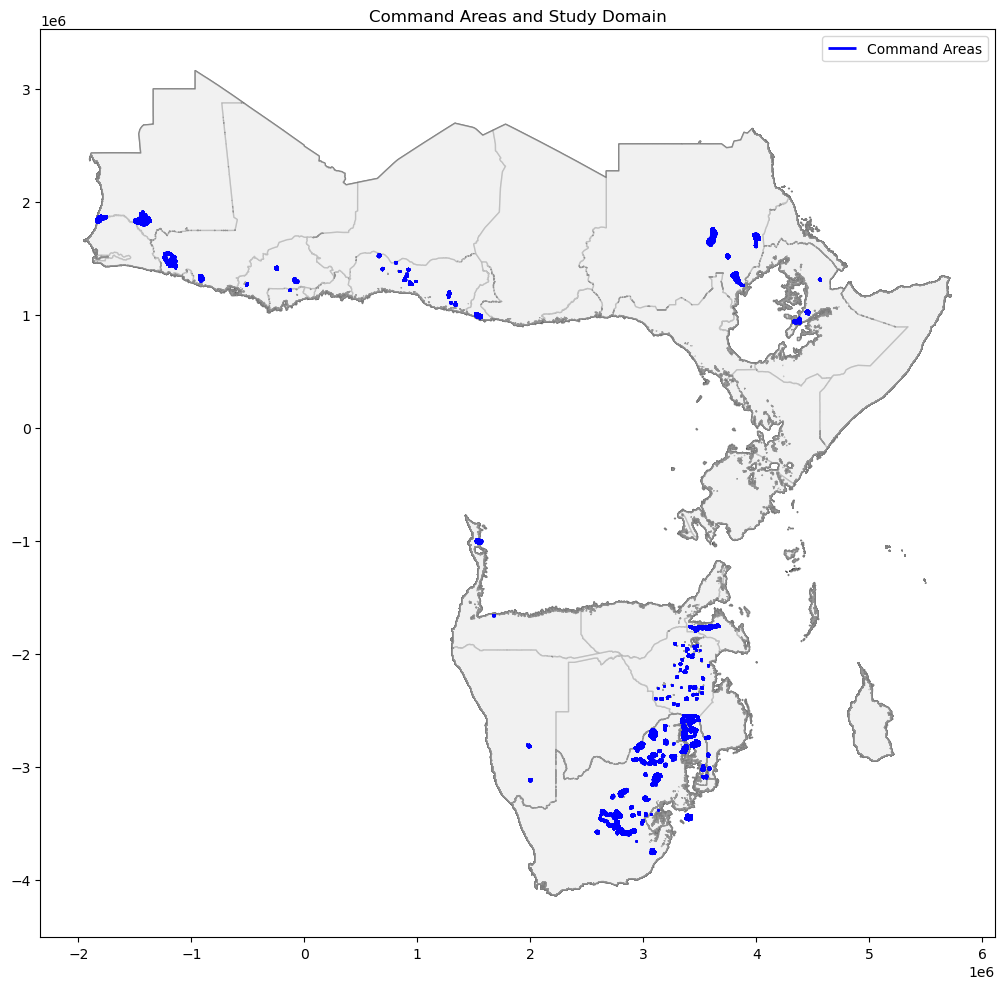

In [9]:

# Visualize Command Areas and Study Domain
fig, ax = plt.subplots(figsize=(12, 10))
if os.path.exists(ssa_arid_shp_fp):
    study_area.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Study Area')
total_outside_area.plot(ax=ax, color='whitesmoke', edgecolor='gray', alpha=0.7, label='Outside Area')
total_command_area.boundary.plot(ax=ax, color='blue', linewidth=2, label='Command Areas')
plt.title('Command Areas and Study Domain')
plt.legend()
plt.tight_layout()
#plt.savefig('command_areas_study_domain.png', dpi=300)
plt.show()
#print('Saved map: command_areas_study_domain.png')


## 8. Visualize Sampled Irrigation Data Extraction (2015)

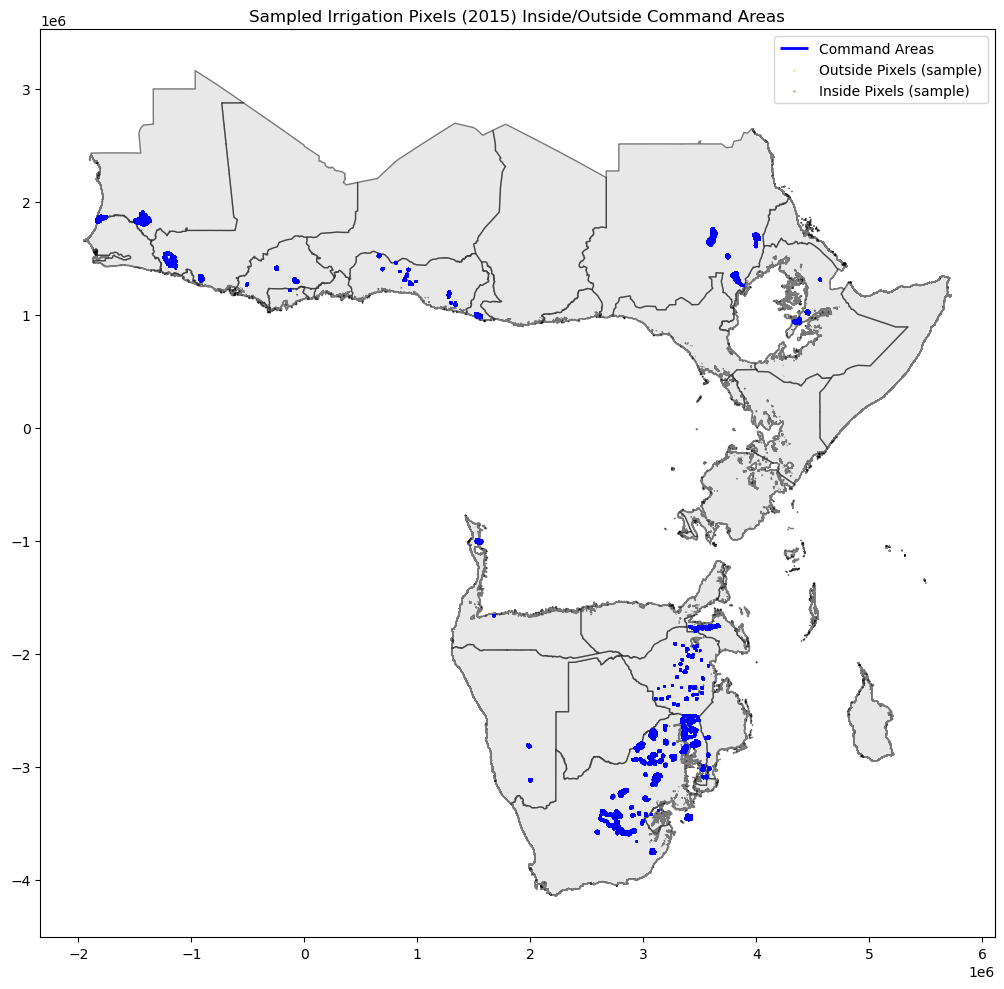

In [10]:

# Visualize Sampled Irrigation Data Extraction (2015)
# Sample up to 5000 points for each region for visualization
sample_n = 5000
inside_sample = inside_pixels_2015 if len(inside_pixels_2015) <= sample_n else np.random.choice(inside_pixels_2015, sample_n, replace=False)
outside_sample = outside_pixels_2015 if len(outside_pixels_2015) <= sample_n else np.random.choice(outside_pixels_2015, sample_n, replace=False)

# For visualization, get coordinates of nonzero pixels (approximate, not exact locations)
def get_pixel_coords(raster_fp, mask_geom, sample_n):
    with rasterio.open(raster_fp) as src:
        out_image, out_transform = rasterio.mask.mask(src, [mapping(mask_geom)], crop=False, filled=True)
        arr = out_image[0]
        mask = arr != src.nodata
        coords = np.column_stack(np.where(mask))
        # Convert array indices to spatial coordinates
        xs, ys = rasterio.transform.xy(src.transform, coords[:,0], coords[:,1])
        # Sample
        if len(xs) > sample_n:
            idx = np.random.choice(len(xs), sample_n, replace=False)
            xs = np.array(xs)[idx]
            ys = np.array(ys)[idx]
        return xs, ys

inside_xs, inside_ys = get_pixel_coords(irrig_raster_2015_path, inside_geom, sample_n)
outside_xs, outside_ys = get_pixel_coords(irrig_raster_2015_path, outside_geom, sample_n)

fig, ax = plt.subplots(figsize=(12, 10))
if os.path.exists(ssa_arid_shp_fp):
    study_area.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
total_command_area.boundary.plot(ax=ax, color='blue', linewidth=2, label='Command Areas')
ax.scatter(outside_xs, outside_ys, s=1, color='orange', alpha=0.3, label='Outside Pixels (sample)')
ax.scatter(inside_xs, inside_ys, s=1, color='green', alpha=0.3, label='Inside Pixels (sample)')
plt.title('Sampled Irrigation Pixels (2015) Inside/Outside Command Areas')
plt.legend()
plt.tight_layout()
#plt.savefig('sampled_irrigation_pixels_2015.png', dpi=300)
plt.show()
#print('Saved map: sampled_irrigation_pixels_2015.png')
